     tweet_id   sentiment                                            content
0  1956967341       empty  @tiffanylue i know  i was listenin to bad habi...
1  1956967666     sadness  Layin n bed with a headache  ughhhh...waitin o...
2  1956967696     sadness                Funeral ceremony...gloomy friday...
3  1956967789  enthusiasm               wants to hang out with friends SOON!
4  1956968416     neutral  @dannycastillo We want to trade with someone w...
tweet_id     0
sentiment    0
content      0
dtype: int64
0
sentiment
neutral       8638
worry         8459
happiness     5209
sadness       5165
love          3842
surprise      2187
fun           1776
relief        1526
hate          1323
empty          827
enthusiasm     759
boredom        179
anger          110
Name: count, dtype: int64


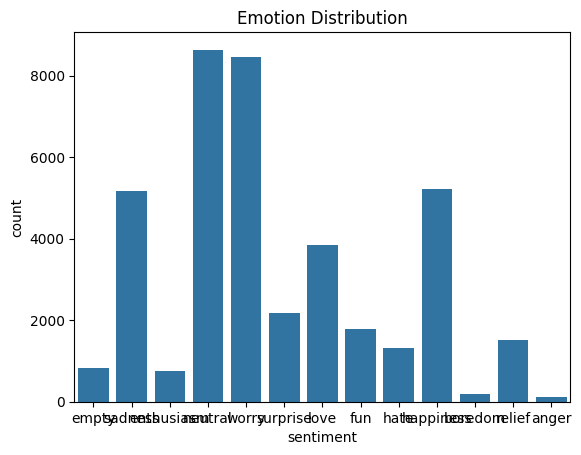

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        19
           1       0.03      0.03      0.03        31
           2       0.03      0.15      0.06       162
           3       0.03      0.06      0.04       163
           4       0.09      0.11      0.10       338
           5       0.29      0.24      0.26      1028
           6       0.20      0.31      0.24       268
           7       0.39      0.41      0.40       762
           8       0.36      0.26      0.30      1740
           9       0.10      0.12      0.11       352
          10       0.28      0.25      0.26      1046
          11       0.09      0.10      0.10       425
          12       0.35      0.28      0.31      1666

    accuracy                           0.25      8000
   macro avg       0.17      0.18      0.17      8000
weighted avg       0.28      0.25      0.26      8000

 Model, Vectorizer, and Label Encoder Loaded Successfully!



Enter a sentence to analyze emotion (or type 'exit' to stop):  wow!


 Predicted Emotion: enthusiasm




Enter a sentence to analyze emotion (or type 'exit' to stop):  she is beautiful, look at her eyes


 Predicted Emotion: fun




Enter a sentence to analyze emotion (or type 'exit' to stop):  I want to kick him


 Predicted Emotion: neutral




Enter a sentence to analyze emotion (or type 'exit' to stop):  lets think before doing it


 Predicted Emotion: neutral




Enter a sentence to analyze emotion (or type 'exit' to stop):  Yesterday was little hard 


 Predicted Emotion: worry




Enter a sentence to analyze emotion (or type 'exit' to stop):  we will sing together 


 Predicted Emotion: neutral




Enter a sentence to analyze emotion (or type 'exit' to stop):  Hello! gauri here


 Predicted Emotion: enthusiasm




Enter a sentence to analyze emotion (or type 'exit' to stop):  I saw Priya crying and sitting alone in the ground 


 Predicted Emotion: relief




Enter a sentence to analyze emotion (or type 'exit' to stop):  reena was crying 


 Predicted Emotion: neutral




Enter a sentence to analyze emotion (or type 'exit' to stop):  exit


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import neattext.functions as nfx
import joblib
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("C:/Users/LENOVO/OneDrive/Desktop/tweet_emotions.csv")

# Show dataset info
print(df.head())
print(df.isnull().sum())
print(df.duplicated().sum())
print(df['sentiment'].value_counts())

# Plot emotion distribution
sns.countplot(x=df['sentiment'])
plt.title("Emotion Distribution")
plt.show()

# Function to clean text
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = nfx.remove_urls(text)  # Remove URLs
    text = nfx.remove_puncts(text)  # Remove punctuations
    text = nfx.remove_stopwords(text)  # Remove stopwords
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

df['cleaned_text'] = df['content'].apply(clean_text)

# Encode sentiment labels
encoder = LabelEncoder()
df['emotion_label'] = encoder.fit_transform(df['sentiment'])

# Save label encoder
joblib.dump(encoder.classes_, "label_encoder.pkl")

# Prepare data
X = df['cleaned_text']
y = df['emotion_label']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TF-IDF Vectorization (reduced max features)
vectorizer = TfidfVectorizer(max_features=7000, ngram_range=(1,1))  # Unigrams only
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Save vectorizer
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")

# Apply SMOTE to balance dataset
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)

# Train Random Forest Model with reduced complexity
rf_model = RandomForestClassifier(n_estimators=150, random_state=42, n_jobs=-1)
rf_model.fit(X_train_resampled, y_train_resampled)

# Save trained model
joblib.dump(rf_model, "emotion_classifier.pkl")

# Make predictions
y_pred = rf_model.predict(X_test_tfidf)

# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
print(classification_report(y_test, y_pred))

# Load Model for Testing
loaded_model = joblib.load("emotion_classifier.pkl")
loaded_vectorizer = joblib.load("tfidf_vectorizer.pkl")
encoder = LabelEncoder()
encoder.classes_ = joblib.load("label_encoder.pkl")

print(" Model, Vectorizer, and Label Encoder Loaded Successfully!")

# Real-time Emotion Detection
while True:
    user_text = input("\nEnter a sentence to analyze emotion (or type 'exit' to stop): ")
    if user_text.lower() == "exit":
        break

    user_features = loaded_vectorizer.transform([user_text])
    predicted_emotion = loaded_model.predict(user_features)
    predicted_label = encoder.inverse_transform(predicted_emotion)
    print(f" Predicted Emotion: {predicted_label[0]}\n")